# Data Analysis Process
In this notebook, we are working on analyzing the enriched versions of Book-Crossing that we created in A. Data Enrichment Process.



## 0. Import Libraries
First, we are importing libraries that are needed for our process.

In [1]:
import time
import pandas as pd
import numpy as np
import pickle as pkl
from collections import Counter
import re
import math
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pywaffle import Waffle
from scipy.signal import find_peaks
from itertools import chain


We are setting the locations where we are saving our output files. The "large" location is used for files too large to be added on github - hence they are ignored during the git commit.

In [2]:
location_to_save = "data/final_files/"
large_location_to_save = "data/final_files/large_files/"

## 1. Analyze datasets

Read files. We are using the final versions of the datasets.

In [140]:
entire_books = pd.read_csv(location_to_save+"items_books_with_readable_properties_correct_ISBN.csv", low_memory=False, index_col=0).fillna("")
fairbook_books = pd.read_csv(location_to_save+"fairbook_books_with_readable_properties_correct_ISBN.csv", low_memory=False, index_col=0).fillna("")
entire_ratings = pd.read_csv(large_location_to_save+"entire_ratings_with_readable_properties_filtered_correct_ISBNs.csv", low_memory=False, index_col=0).fillna("")
fairbook_ratings = pd.read_csv(location_to_save+"fairbook_ratings_with_readable_properties_filtered_correct_ISBNs.csv", low_memory=False, index_col=0).fillna("")

<b>Note</b>: The entire_books and fairbook_books datasets still have the old ISBN column, which means some books are duplicate. We will drop based on ISBN_alt.

In [141]:
entire_books = entire_books.drop_duplicates("ISBN_alt")
fairbook_books = fairbook_books.drop_duplicates("ISBN_alt")

In [142]:
# gather all the datasets
dfs = [entire_books.copy(), entire_ratings.copy(), fairbook_books.copy(), fairbook_ratings.copy()]

In [143]:
dfs_names = ['entire books', 'entire ratings', 'fairbook books', 'fairbook ratings']

Choose color map.

In [144]:
color_map=mcp.gen_color(cmap="Pastel2",n=8)
print(color_map)

['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4', '#e6f5c9', '#fff2ae', '#f1e2cc', '#cccccc']


### 1.a. Gender
<b>Goal</b>: To analyze the gender distribution in the datasets.

Overview.

In [145]:
i=0
print("===============")
for df in dfs:
    print(dfs_names[i]+":")
    print("---------------")
    print(Counter(df.gender).most_common()[:5])
    print("===============")
    i+=1

entire books:
---------------
[('male', 86800), ('', 79013), ('female', 50655), ('transgender female', 57), ('male,female', 47)]
entire ratings:
---------------
[('male', 466151), ('female', 375316), ('', 179688), ('transgender male', 292), ('transgender female', 163)]
fairbook books:
---------------
[('male', 2605), ('female', 2466), ('', 425), ('transgender male', 4), ('transgender female', 3)]
fairbook ratings:
---------------
[('male', 42933), ('female', 39847), ('', 3515), ('transgender male', 34), ('transgender female', 22)]



Given how the big majority of the authors are either flagged as "male" or "female", we for now focus on these two cases. <u>However, this should be resolved in future iteration.</u> 

In [146]:
for df in dfs:
    # replace empty string with "unknown"
    df["gender"] = df["gender"].apply(lambda x: "unknown" if x=="" else x)
    # flag as "other" if neither male, nor female, nor unknown
    df["gender"] = df["gender"].apply(lambda x: "other" if (x!="male")&(x!="female")&(x!="unknown") else x) 

Set color for every gender value.

In [147]:
colors = {}
i = 0
for gender_value in dfs[0].gender.unique(): #entire_books definitely contains all possible values
    colors[gender_value] = color_map[i]
    i+=1

In [148]:
print(colors)

{'unknown': '#b3e2cd', 'male': '#fdcdac', 'female': '#cbd5e8', 'other': '#f4cae4'}


Make graphs.

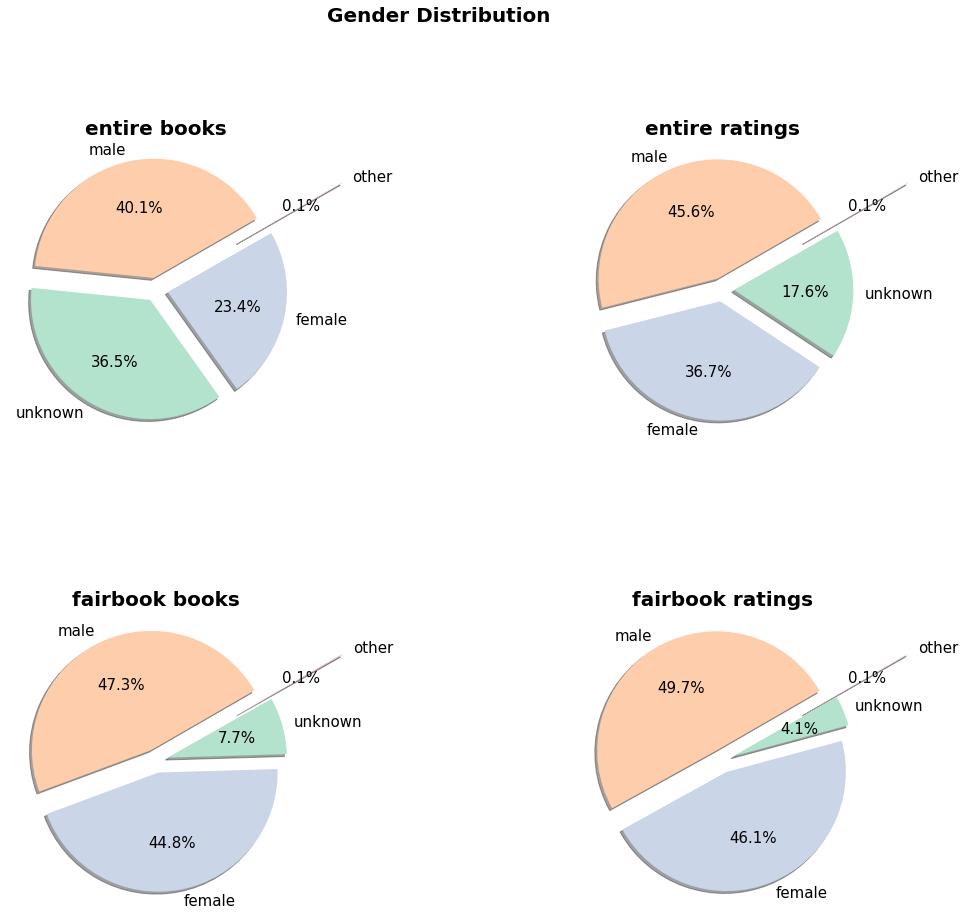

In [149]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
for i in range(len(dfs)):
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    dfs[i].gender.value_counts().plot(kind="pie",autopct='%1.1f%%',explode=(0.1, 0.1, 0.1,0.8), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)],
                                      textprops={'color':'black', 'fontsize':15},
                                     colors=[colors[v] for v in dfs[i]['gender'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].set_title(dfs_names[i],fontdict={'fontsize':20, 'weight':'bold'})
    axes[int(j1),int(j2)].set_ylabel('')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)

fig.suptitle('Gender Distribution',fontsize = 20, weight="bold") 
fig.show()


### 1.b. Country
<b>Goal</b>: To review the author country of citizenship distribution in the datasets.

Overview.

In [128]:
i=0
print("===============")
for df in dfs:
    print(dfs_names[i]+":")
    print("---------------")
    print(Counter(df.country).most_common()[:5])
    print("===============")
    i+=1

entire books:
---------------
[('', 91745), ('United States of America', 70573), ('United Kingdom', 17299), ('France', 3888), ('Canada', 3355)]
entire ratings:
---------------
[('United States of America', 565198), ('', 213253), ('United Kingdom', 85574), ('Canada', 17536), ('France', 11402)]
fairbook books:
---------------
[('United States of America', 3771), ('', 515), ('United Kingdom', 470), ('Canada', 100), ('Republic of Ireland', 46)]
fairbook ratings:
---------------
[('United States of America', 64214), ('United Kingdom', 7847), ('', 4537), ('Canada', 1445), ('Republic of Ireland', 901)]


We notice that each dataset has different most common countries.

Simplify some country names for the graphs.

In [129]:
for df in dfs:
    # replace empty string with "unknown"
    df["country"] = df["country"].apply(lambda x: "unknown" if x=="" else x)
    # simplify country names
    df["country"] = df["country"].apply(lambda x: "USA" if x=="United States of America" else x)
    df["country"] = df["country"].apply(lambda x: "UK" if x=="United Kingdom" else x)
    df["country"] = df["country"].apply(lambda x: "Ireland" if x=="Republic of Ireland" else x)
    

Find most common countries for each dataset.

In [130]:
all_most_common = []
for df in dfs:
    most_common_5 = [x[0] for x in Counter(df.country).most_common()[:5]] # most common countries for this dataset
    all_most_common.append(most_common_5)

In [131]:
all_most_common

[['unknown', 'USA', 'UK', 'France', 'Canada'],
 ['USA', 'unknown', 'UK', 'Canada', 'France'],
 ['USA', 'unknown', 'UK', 'Canada', 'Ireland'],
 ['USA', 'UK', 'unknown', 'Canada', 'Ireland']]

In [132]:
unique_common_countries = list(np.unique(list(chain(*all_most_common))))

In [133]:
unique_common_countries

['Canada', 'France', 'Ireland', 'UK', 'USA', 'unknown']

Change every country to "other" if it is not one of the most common <b>for this dataset</b>.

In [134]:
i=0
for df in dfs:
    df["country"] = df["country"].apply(lambda x: "other" if x not in all_most_common[i] else x)
    i+=1

Add "other" to most common and set colors.

In [135]:
unique_common_countries.append("other")

In [136]:
colors = {}
i = 0
for country_value in unique_common_countries: #entire_books definitely contains all possible values
    colors[country_value] = color_map[i]
    i+=1

Make graphs.

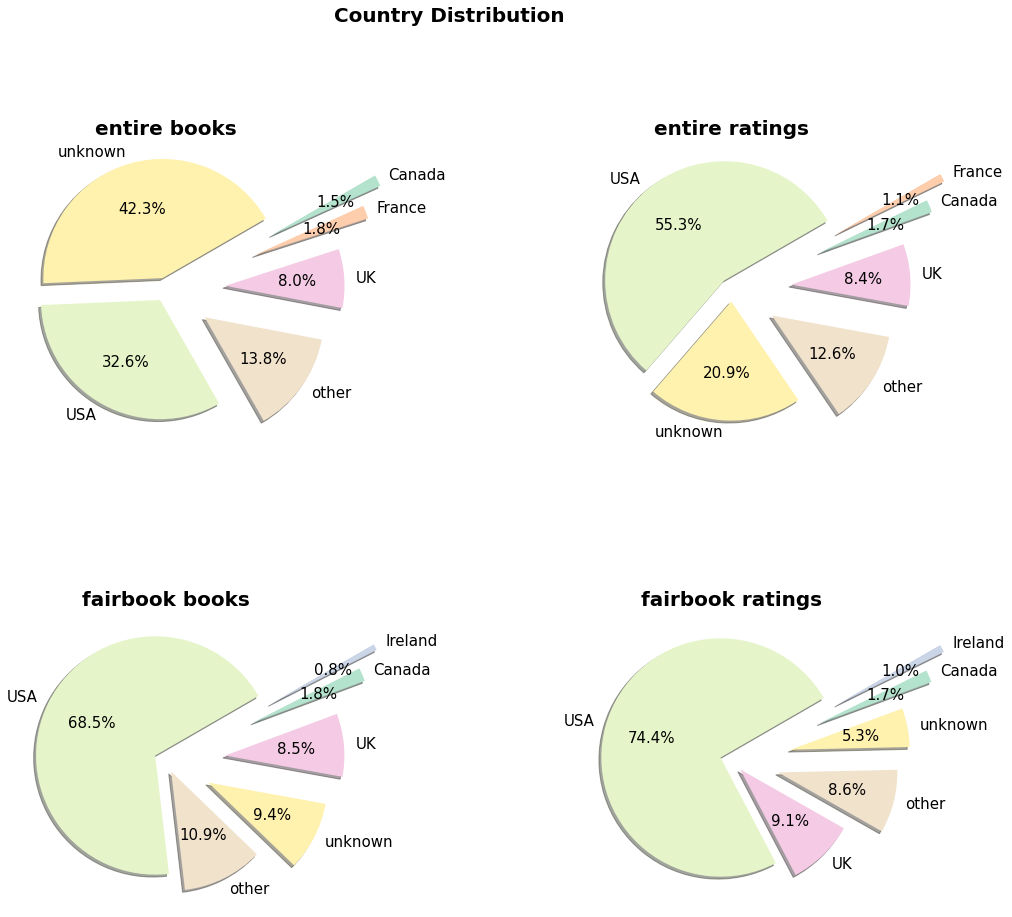

In [138]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
for i in range(len(dfs)):
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    dfs[i].country.value_counts().plot(kind="pie",autopct='%1.1f%%',explode=(0.1, 0.1, 0.4,0.5, 0.8,1), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)],
                                      textprops={'color':'black', 'fontsize':15},
                                     colors=[colors[v] for v in dfs[i]['country'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].set_title(dfs_names[i],fontdict={'fontsize':20, 'weight':'bold'})
    axes[int(j1),int(j2)].set_ylabel('')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)

fig.suptitle('Country Distribution',fontsize = 20, weight="bold") 
fig.show()


### 1.c. Language
<b>Goal</b>: To review the author native language distribution in the datasets.

Overview.

In [150]:
i=0
print("===============")
for df in dfs:
    print(dfs_names[i]+":")
    print("---------------")
    print(Counter(df.language).most_common()[:5])
    print("===============")
    i+=1

entire books:
---------------
[('', 189987), ('English', 18593), ('French', 1955), ('German', 1079), ('Spanish', 675)]
entire ratings:
---------------
[('', 791587), ('English', 189754), ('French', 7253), ('Spanish', 4522), ('German', 4034)]
fairbook books:
---------------
[('', 4065), ('English', 1265), ('Spanish', 24), ('French', 19), ('British English', 18)]
fairbook ratings:
---------------
[('', 57955), ('English', 25770), ('Spanish', 366), ('British English', 341), ('English,American English', 299)]


We notice that each dataset has different most common countries.

In [151]:
for df in dfs:
    df["language"] = df["language"].apply(lambda x: "unknown" if x=="" else x)

Find most common countries for each dataset.

In [152]:
all_most_common = []
for df in dfs:
    most_common_5 = [x[0] for x in Counter(df.language).most_common()[:5]] # most common languages for this dataset
    all_most_common.append(most_common_5)

In [153]:
all_most_common

[['unknown', 'English', 'French', 'German', 'Spanish'],
 ['unknown', 'English', 'French', 'Spanish', 'German'],
 ['unknown', 'English', 'Spanish', 'French', 'British English'],
 ['unknown',
  'English',
  'Spanish',
  'British English',
  'English,American English']]

In [154]:
unique_common_languages = list(np.unique(list(chain(*all_most_common))))

In [155]:
unique_common_languages

['British English',
 'English',
 'English,American English',
 'French',
 'German',
 'Spanish',
 'unknown']

Change every language to "other" if it is not one of the most common <b>for this dataset</b>.

In [156]:
i=0
for df in dfs:
    df["language"] = df["language"].apply(lambda x: "other" if x not in all_most_common[i] else x)
    i+=1

Add "other" to most common and set colors.

In [157]:
unique_common_languages.append("other")

In [158]:
colors = {}
i = 0
for language_value in unique_common_languages: #entire_books definitely contains all possible values
    colors[language_value] = color_map[i]
    i+=1

Make graphs.

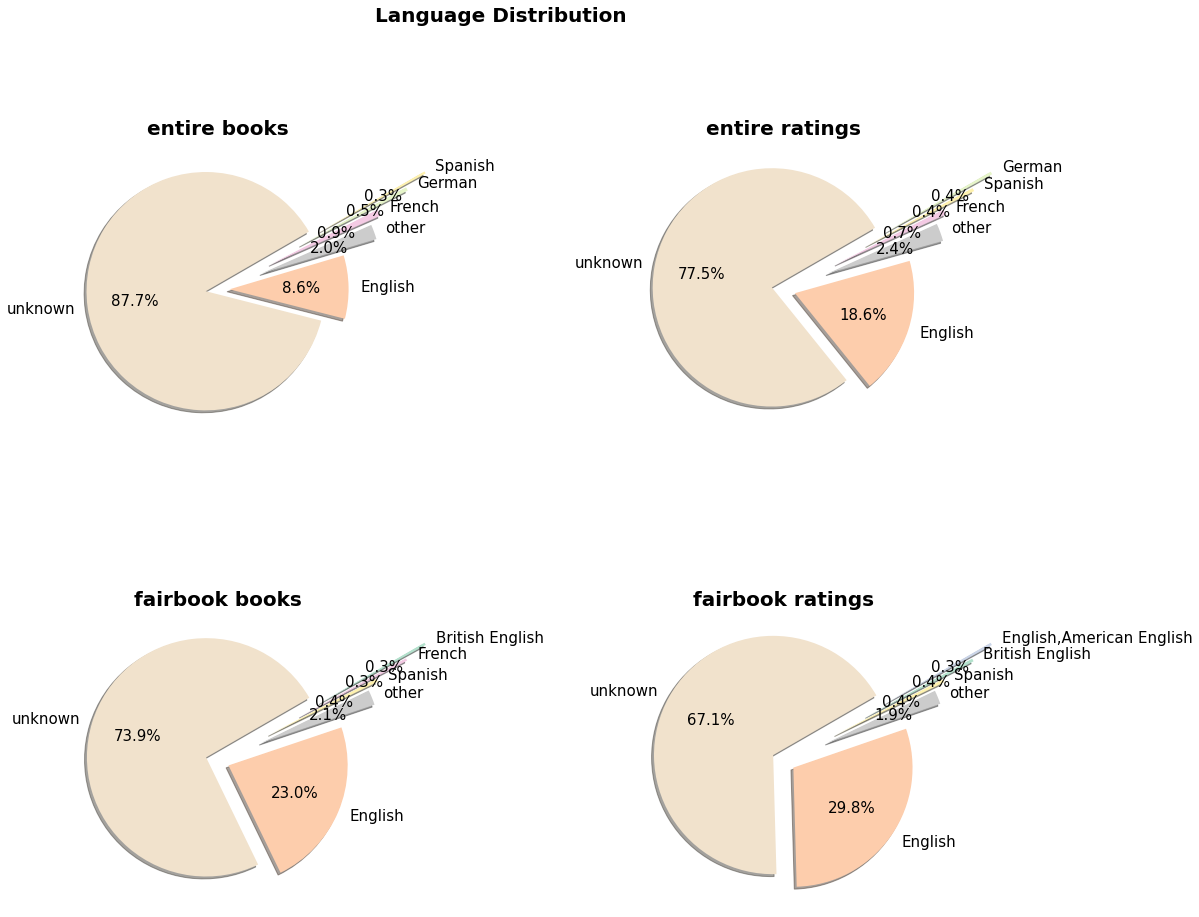

In [159]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
for i in range(len(dfs)):
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    dfs[i].language.value_counts().plot(kind="pie",autopct='%1.1f%%',explode=(0.1, 0.1, 0.4,0.5, 0.8,1), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)],
                                      textprops={'color':'black', 'fontsize':15},
                                     colors=[colors[v] for v in dfs[i]['language'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].set_title(dfs_names[i],fontdict={'fontsize':20, 'weight':'bold'})
    axes[int(j1),int(j2)].set_ylabel('')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)

fig.suptitle('Language Distribution',fontsize = 20, weight="bold") 
fig.show()


### 1.d. Birthyear
<b>Goal</b>: To review the author birth year distribution in the datasets.

Overview.

In [160]:
i=0
print("===============")
for df in dfs:
    print(dfs_names[i]+":")
    print("---------------")
    print(Counter(df.birthyear).most_common()[:5])
    print("===============")
    i+=1

entire books:
---------------
[('', 81051), (1947.0, 4166), (1950.0, 4020), (1946.0, 3730), (1948.0, 3597)]
entire ratings:
---------------
[('', 186755), (1947.0, 46577), (1950.0, 31945), (1948.0, 30273), (1955.0, 26390)]
fairbook books:
---------------
[('', 448), (1947.0, 331), (1950.0, 236), (1948.0, 220), (1952.0, 178)]
fairbook ratings:
---------------
[(1947.0, 6685), (1950.0, 3977), ('', 3749), (1955.0, 3714), (1948.0, 3291)]


We have to analyze birthyear differently given the continuous values.

In [161]:
for df in dfs:
    df["birthyear"] = df["birthyear"].apply(lambda x: "unknown" if x=="" else x)

Make histogram to review birth year distribution.

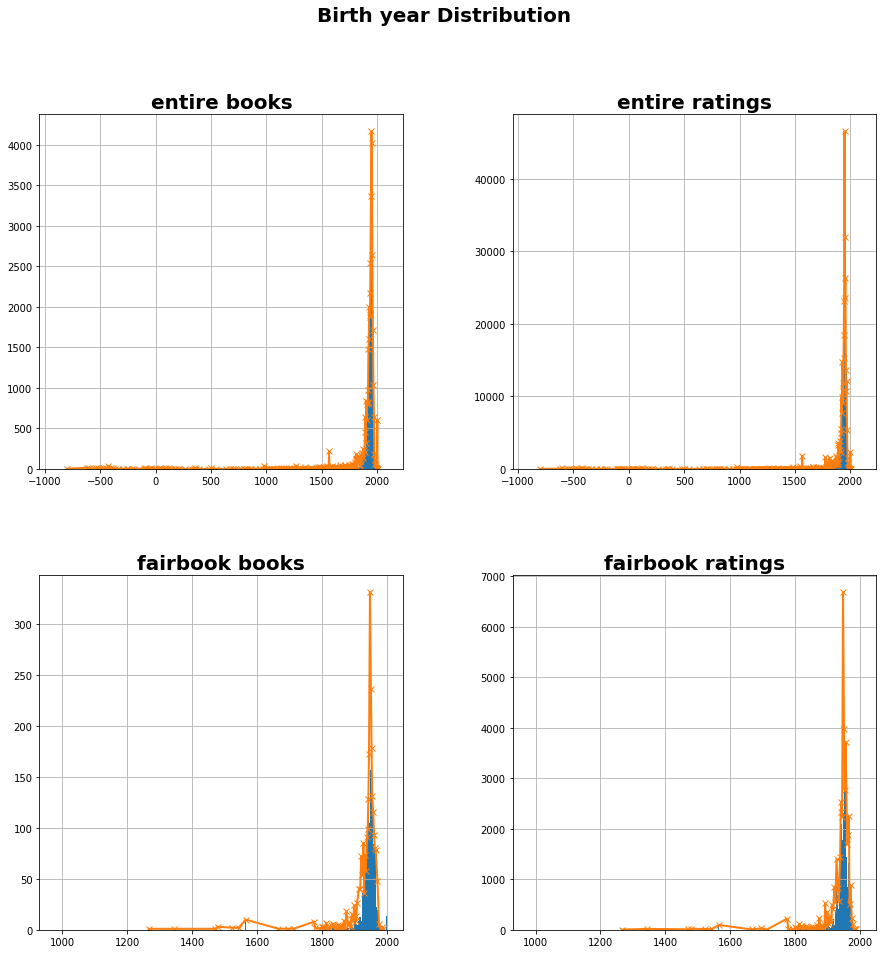

In [180]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
for i in range(len(dfs)):
    new_df = dfs[i][dfs[i].birthyear!="unknown"]
    new_df_birthyear = new_df.birthyear.astype("float")
    max_frequency = new_df_birthyear.value_counts().max()
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    
    n = math.ceil((new_df_birthyear.max() - new_df_birthyear.min()))
    pd.DataFrame(new_df_birthyear).hist(column="birthyear", bins=n,ax=axes[int(j1),int(j2)])
    
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].set_title(dfs_names[i],fontdict={'fontsize':20, 'weight':'bold'})
    
    
    hist, bin_edges = np.histogram(list(new_df_birthyear), int(max(new_df_birthyear)-min(new_df_birthyear)))
    bin_edges = bin_edges[1:]
    peaks, _ = find_peaks(hist)
    axes[int(j1),int(j2)].plot(bin_edges[peaks], hist[peaks],linewidth=2, marker ='x')
fig.suptitle('Birth year Distribution',fontsize = 20, weight="bold") 
fig.show()

We see that most birthyears are as expected concentrated in the 20th century.

Categorize the birth years.

In [181]:
for df in dfs:
    df["birthyear_coded"] = df["birthyear"].apply(lambda x: "1000000" if x=="unknown" else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "2000000" if int(x)<0 else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "3000000" if (int(x)>=0)&(int(x)<1900) else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "4000000" if (int(x)>=1900)&(int(x)<1950) else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "5000000" if (int(x)>=1950)&(int(x)<200000) else x)

In [182]:
for df in dfs:
    df.birthyear_coded = df.birthyear_coded.replace("1000000","unknown")
    df.birthyear_coded = df.birthyear_coded.replace("2000000","B.C.")
    df.birthyear_coded = df.birthyear_coded.replace("3000000","0-1900")
    df.birthyear_coded = df.birthyear_coded.replace("4000000","1900-1950")
    df.birthyear_coded = df.birthyear_coded.replace("5000000","1950-2000")

In [183]:
unique_birthyear_categories = dfs[0].birthyear_coded.unique()

In [185]:
colors = {}
i = 0
for birthyear_value in unique_birthyear_categories:
    colors[birthyear_value] = color_map[i]
    i+=1

Make pie charts.

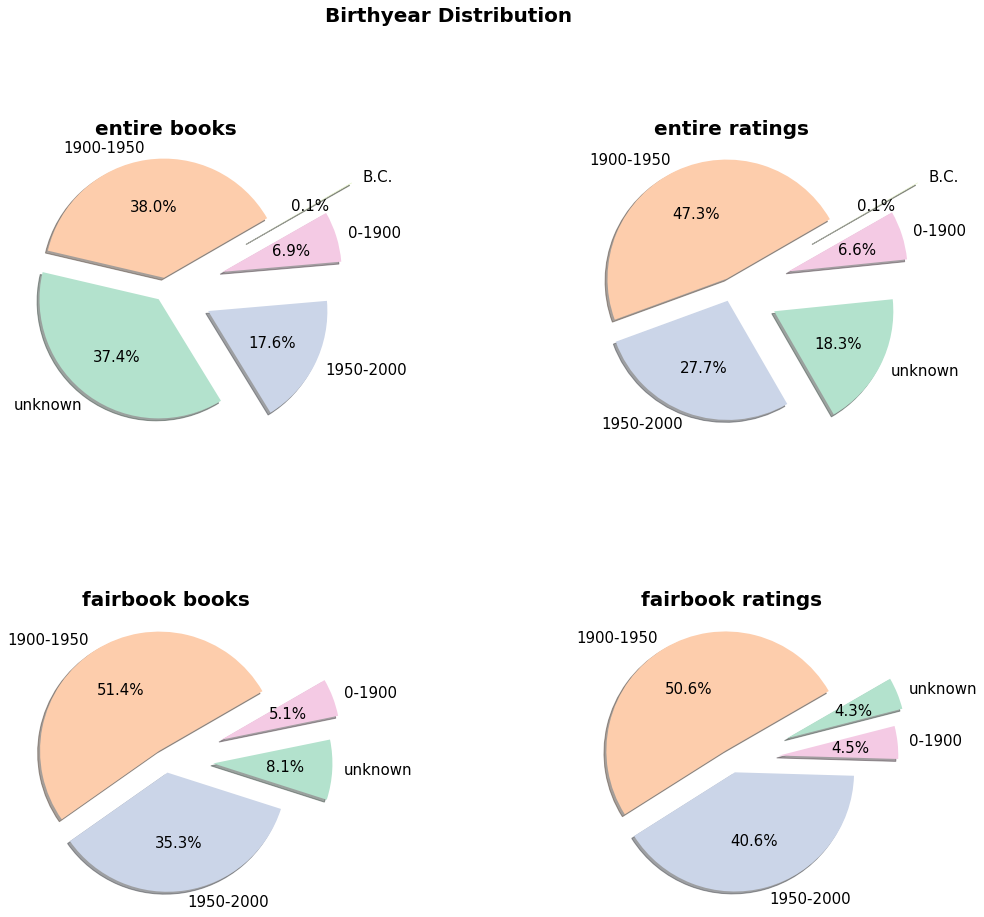

In [194]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
for i in range(len(dfs)):
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    explode=(0.1, 0.1, 0.4,0.5, 0.8)
    explode = explode[:len(dfs[i].birthyear_coded.unique())] # fairbook datasets don't have all the possible values
    dfs[i].birthyear_coded.value_counts().plot(kind="pie",autopct='%1.1f%%',explode=explode, shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)],
                                      textprops={'color':'black', 'fontsize':15},
                                     colors=[colors[v] for v in dfs[i]['birthyear_coded'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].set_title(dfs_names[i],fontdict={'fontsize':20, 'weight':'bold'})
    axes[int(j1),int(j2)].set_ylabel('')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)

fig.suptitle('Birthyear Distribution',fontsize = 20, weight="bold") 
fig.show()


Let's zoom even more in the 20th century.

In [195]:
for df in dfs:
    for index, row in df.iterrows():
        if (row.birthyear_coded == "1950-2000") | (row.birthyear_coded == "1900-1950"):
            year = row.birthyear
            year_rounded_down = math.floor(year/10)*10
            df.at[index, "birthyear_coded"] = str(year_rounded_down)+"s"

In [196]:
dfs[0].birthyear_coded.unique()

array(['unknown', '1930s', '1940s', '1950s', '1960s', '1970s', '0-1900',
       '1920s', '1900s', '1910s', '2000s', '1980s', '1990s', 'B.C.',
       '2080s'], dtype=object)

In [198]:
unique_birthyear_categories = dfs[0].birthyear_coded.unique()

In [200]:
len(unique_birthyear_categories)

15

Update color map.

In [206]:
color_map=mcp.gen_color(cmap="tab20b",n=15)
print(color_map)

['#393b79', '#5254a3', '#6b6ecf', '#637939', '#8ca252', '#cedb9c', '#8c6d31', '#e7ba52', '#e7cb94', '#843c39', '#d6616b', '#e7969c', '#a55194', '#ce6dbd', '#de9ed6']


In [209]:
colors = {}
i = 0
for birthyear_value in unique_birthyear_categories:
    colors[birthyear_value] = color_map[len(color_map)-i-1]
    i+=1

Make pie graphs about the distribution of birthyears among the 20th century decades.

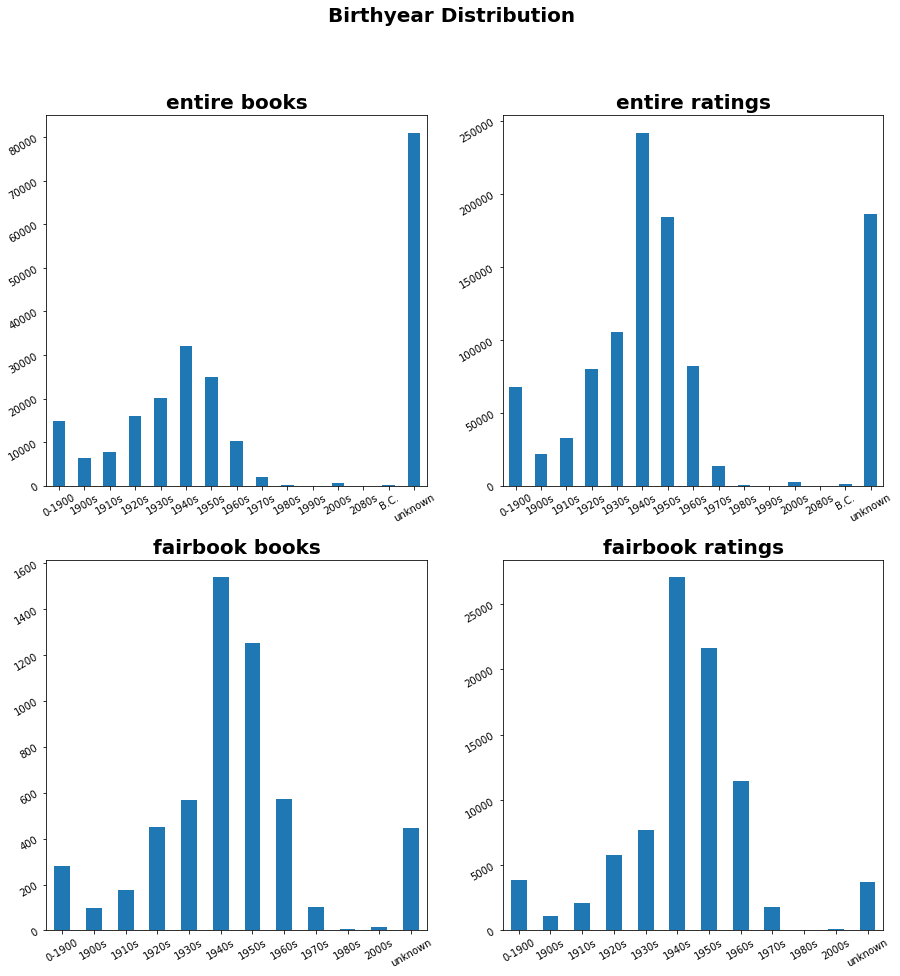

In [235]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
for i in range(len(dfs)):
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    
    dfs[i].birthyear_coded.value_counts().sort_index().plot(kind="bar",ax=axes[int(j1),int(j2)])
                                     

    axes[int(j1),int(j2)].tick_params(labelrotation=30)
    axes[int(j1),int(j2)].set_title(dfs_names[i],fontdict={'fontsize':20, 'weight':'bold'})
    axes[int(j1),int(j2)].set_ylabel('')


fig.suptitle('Birthyear Distribution',fontsize = 20, weight="bold") 
fig.show()
